In [1]:
from numpy.random import seed
seed(42)

import tensorflow as tf
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

In [2]:
from tensorflow.python.keras.callbacks import TensorBoard

from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective_2D #, plot_histogram
from tensorflow.python.keras import backend as K

from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import datetime as dt

from sklearn.preprocessing import StandardScaler

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall', 'fp', 'fn']
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
        
    elif metric == 'auc':
        plt.ylim([0.8,1])
        
    else:
        #plt.ylim([0,1])
        plt.legend()

def multivariate_data(
    dataset,
    target, 
    start_index, 
    end_index, 
    history_size,
    target_size, 
    step
):
    
    data = []
    labels = []

    start_index = start_index + history_size
    
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        labels.append(target[i+target_size])

    return np.array(data), np.array(labels)

def log_dir_name(
    learning_rate,
    past_history,
    lstm_units,
    hidden_layers,
    hidden_units,
    #lstm_l2_lambda,
    hidden_l2_lambda,
    class_0_weight,
    class_1_weight
):

    # The dir-name for the TensorBoard log-dir.
    s = "./LSTM_logs/past_history_{1}_hidden_layers_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(
        learning_rate,
        past_history,
        lstm_units,
        hidden_layers,
        hidden_units,
        #lstm_l2_lambda,
        hidden_l2_lambda,
        class_0_weight,
        class_1_weight
    )

    return log_dir

def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * ((precision*10) * recall) / ((precision*10) + recall + K.epsilon())
    
    return f1_val

In [4]:
data_file = '../data/training_data/1992-2015_training_data_added_features.csv'

# Datatypes for dataframe loading
dtypes = {
    'lat': float,
    'lon': float,
    'weather_bin_year': int,
    'weather_bin_month': int,
    'weather_bin_day': int,
    'air.2m': float,
    'apcp': float,
    'rhum.2m': float,
    'dpt.2m': float,
    'pres.sfc': float,
    'uwnd.10m': float,
    'vwnd.10m': float,
    'veg': float,
    'vis': float,
    'ignition': float,
    'mean.air.2m': float,
    'mean.apcp': float,
    'mean.rhum.2m': float,
    'mean.dpt.2m': float,
    'mean.pres.sfc': float,
    'mean.uwnd.10m': float,
    'mean.vwnd.10m': float,
    'mean.veg': float,
    'mean.vis': float,
    'max.air.2m': float,
    'max.apcp': float,
    'max.rhum.2m': float,
    'max.dpt.2m': float,
    'max.pres.sfc': float,
    'max.uwnd.10m': float,
    'max.vwnd.10m': float,
    'max.veg': float,
    'max.vis': float,
    'min.air.2m': float,
    'min.apcp': float,
    'min.rhum.2m': float,
    'min.dpt.2m': float,
    'min.pres.sfc': float,
    'min.uwnd.10m': float,
    'min.vwnd.10m': float,
    'min.veg': float,
    'min.vis': float,
    'total_fires': float

}

# Features to use during training 
features = [
    'lat',
    'lon',
    'weather_bin_month',
    'veg',
    'ignition',
    'mean.air.2m',
    'mean.apcp',
    'mean.rhum.2m',
    'mean.dpt.2m',
    'mean.pres.sfc',
    'mean.uwnd.10m',
    'mean.vwnd.10m',
    'mean.veg',
    'mean.vis',
    'mean.air.2m',
    'mean.apcp',
    'mean.rhum.2m',
    'mean.dpt.2m',
    'mean.pres.sfc',
    'mean.uwnd.10m',
    'mean.vwnd.10m',
    'mean.vis',
    'max.air.2m',
    'max.apcp',
    'max.rhum.2m',
    'max.dpt.2m',
    'max.pres.sfc',
    'max.uwnd.10m',
    'max.vwnd.10m',
    'max.vis',
    'min.air.2m',
    'min.apcp',
    'min.rhum.2m',
    'min.dpt.2m',
    'min.pres.sfc',
    'min.uwnd.10m',
    'min.vwnd.10m',
    'min.vis',
    'total_fires'
]

features_to_scale = [
    'veg',
    'mean.air.2m',
    'mean.apcp',
    'mean.rhum.2m',
    'mean.dpt.2m',
    'mean.pres.sfc',
    'mean.uwnd.10m',
    'mean.vwnd.10m',
    'mean.vis',
    'max.air.2m',
    'max.apcp',
    'max.rhum.2m',
    'max.dpt.2m',
    'max.pres.sfc',
    'max.uwnd.10m',
    'max.vwnd.10m',
    'max.vis',
    'min.air.2m',
    'min.apcp',
    'min.rhum.2m',
    'min.dpt.2m',
    'min.pres.sfc',
    'min.uwnd.10m',
    'min.vwnd.10m',
    'min.vis',
    'total_fires'
]

In [5]:
raw_data = pd.read_csv(data_file, index_col=0, parse_dates=True, dtype=dtypes)

In [6]:
# Pull out columns of intrest
data = raw_data[features]

In [7]:
# Pick one spatial bin with fires
data = data[(data['lat'] == 39.42233) & (data['lon'] == -120.6546)]

In [8]:
# Also drop lat, lon, day and year columns (unnecessary)
data.drop(['lat', 'lon'], axis=1, inplace=True)

In [9]:
# One hot encode month
column_names = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'
]


onehot_encoder = OneHotEncoder(sparse=False)

# Training data
month = np.array(data['weather_bin_month']).reshape(-1, 1)
onehot_month = onehot_encoder.fit_transform(month)

data.drop('weather_bin_month', axis=1, inplace=True)
onehot_month_df = pd.DataFrame(onehot_month, columns=column_names)

onehot_month_df['datetime'] = pd.to_datetime(data.index)
onehot_month_df = onehot_month_df.set_index('datetime')
data = pd.concat([data, onehot_month_df], axis=1)

In [10]:
# Scale data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features_to_scale])
data[features_to_scale] = scaled_features

In [11]:
# Sort by date time index
# one_bin_training_data = one_bin_training_data.sort_index()
data = data.sort_index()

In [12]:
data.head()

,veg,ignition,mean.air.2m,mean.apcp,mean.rhum.2m,mean.dpt.2m,mean.pres.sfc,mean.uwnd.10m,mean.vwnd.10m,mean.veg,...,March,April,May,June,July,August,Septermber,October,November,December
1992-01-01,0.503702,0.0,-1.138237,-0.368419,-0.485131,-1.694950,0.575796,-0.787113,0.389269,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-02,0.503702,0.0,-0.916780,-0.359414,-0.717171,-1.648949,-0.455567,-0.610320,-0.105418,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-03,0.503702,0.0,-1.003120,0.155398,0.521572,-0.763310,-1.945359,0.406430,0.978409,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-04,0.503702,0.0,-1.013071,1.580237,1.798763,0.130060,-2.642089,0.746722,2.634629,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-05,0.503702,0.0,-1.245384,0.645080,1.815982,-0.175384,-3.348068,0.378398,1.619435,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Split data up into training, testing and validation sets
test_data = data.tail(int(len(data)*0.1))
leftover_data = data.iloc[:-int(len(data)*0.1)]

validation_data = data.tail(int(len(leftover_data)*0.3))
training_data = data.iloc[:-int(len(leftover_data)*0.3)]

In [14]:
# Convert to numpy arrays
training_data = np.array(training_data)
validation_data = np.array(validation_data)
test_data = np.array(test_data)

In [15]:
future_target = 1
step = 1

initial_bias = -1.4
output_bias = tf.keras.initializers.Constant(initial_bias)

# weight_for_0 = 0.5 
# weight_for_1 = 13
# class_weight = {0: weight_for_0, 1: weight_for_1}

EPOCHS = 15
BATCH_SIZE = 100
STEPS_PER_EPOCH = (len(training_data) * 0.25) // BATCH_SIZE
VALIDATION_STEPS = (len(validation_data) * 0.25) // BATCH_SIZE

path_best_model = '../trained_models/best_skopt_LTSM.keras'
best_fraction_incorrect = 1.0

metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    f1
]

dim_learning_rate = Real(
    low=0.00001, 
    high=0.1, 
    prior='log-uniform',
    name='learning_rate'
)

dim_past_history = Integer(
    low=1,
    high=30, 
    name='past_history'
)

dim_lstm_units = Integer(
    low=5, 
    high=500,
    name='lstm_units'
)

dim_hidden_layers = Integer(
    low=1, 
    high=10,
    name='hidden_layers'
)

dim_hidden_units = Integer(
    low=5, 
    high=500,
    name='hidden_units'
)

# dim_lstm_l2_lambda = Real(
#     low=0.0001, 
#     high=0.1,
#     prior='log-uniform',
#     name='lstm_l2_lambda'
# )

dim_hidden_l2_lambda = Real(
    low=0.0001, 
    high=0.1,
    prior='log-uniform',
    name='hidden_l2_lambda'
)

dim_class_0_weight = Real(
    low=0.1, 
    high=1,
    name='class_0_weight'
)

dim_class_1_weight = Integer(
    low=10, 
    high=20,
    name='class_1_weight'
)

default_parameters = [0.001, 3, 50, 2, 50, 0.1, 0.5, 15]

dimensions = [
    dim_learning_rate,
    dim_past_history,
    dim_lstm_units,
    dim_hidden_layers,
    dim_hidden_units,
    #dim_lstm_l2_lambda,
    dim_hidden_l2_lambda,
    dim_class_0_weight,
    dim_class_1_weight
]

# Use early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [16]:
def make_model(
    input_dim,
    learning_rate,
    lstm_units,
    hidden_layers,
    hidden_units,
    #lstm_l2_lambda,
    hidden_l2_lambda
):    
    input_shape = (100, input_dim[0], input_dim[1])

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(
        lstm_units,
        batch_input_shape=input_shape,
#         bias_initializer=keras.initializers.VarianceScaling(
#             scale=1.0,
#             mode='fan_in', 
#             distribution='normal', 
#             seed=None
#         ),
#         kernel_regularizer=keras.regularizers.l2(lstm_l2_lambda),
#         activation = 'relu',
         stateful = True
    ))
    for i in range(hidden_layers):
        model.add(keras.layers.Dense(
            hidden_units,
            bias_initializer=keras.initializers.VarianceScaling(
                scale=1.0,
                mode='fan_in', 
                distribution='normal', 
                seed=None
            ),
            kernel_regularizer=keras.regularizers.l2(hidden_l2_lambda),
            activation = 'relu'
        ))

    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr = learning_rate), 
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    past_history,
    lstm_units,
    hidden_layers,
    hidden_units,
    #lstm_l2_lambda,
    hidden_l2_lambda,
    class_0_weight,
    class_1_weight
):

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('past history:', past_history)
    print('LSTM units:', lstm_units)
    print('hidden layers:', hidden_layers)
    print('hidden units:', hidden_units)
    #print('lstm l2 lambda: {0:.1e}'.format(lstm_l2_lambda))
    print('hidden l2 lambda: {0:.1e}'.format(hidden_l2_lambda))
    print('class 0 weight:', class_0_weight)
    print('class 1 weight:', class_1_weight)
    print()
    
    # create data stream
    x_train, y_train = multivariate_data(
        training_data, 
        training_data[:, 1], 
        0,
        None,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = multivariate_data(
        validation_data, 
        validation_data[:, 1], 
        0,
        None,
        past_history,
        future_target, 
        step
    )
    
    start_index = (x_train.shape[0] - (x_train.shape[0] % 100))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % 100))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    
    class_weight = {0: class_0_weight, 1: class_1_weight}
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_dim,
        learning_rate = learning_rate,
        lstm_units = lstm_units,
        hidden_layers = hidden_layers,
        hidden_units = hidden_units,
        #lstm_l2_lambda = lstm_l2_lambda,
        hidden_l2_lambda = hidden_l2_lambda,
    )
    
    model.summary()
    print()

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(
        learning_rate,
        past_history,
        lstm_units,
        hidden_layers,
        hidden_units,
        #lstm_l2_lambda,
        hidden_l2_lambda,
        class_0_weight,
        class_1_weight
    )
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False
    )
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks = [early_stopping],
        validation_data=(x_validation, y_validation),
        validation_steps=VALIDATION_STEPS,
        class_weight=class_weight,
        workers=8
    )

    # Get fraction incorrect on the validation-set
    # after the last training-epoch.
          
    val_fp = history.history['val_fp'][-1]
    val_fn = history.history['val_fn'][-1]
    val_tp = history.history['val_tp'][-1]
    val_tn = history.history['val_tn'][-1]
          
    fraction_incorrect = (val_fn /(val_fn + val_tp + K.epsilon())) + (val_fp / (val_fp + val_tn + K.epsilon()))
    
    print()
    print("Validation fraction incorrect: {0:.2}".format(fraction_incorrect))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_fraction_incorrect

    # If the classification accuracy of the saved model is improved ...
    if fraction_incorrect < best_fraction_incorrect:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_fraction_incorrect = fraction_incorrect

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return fraction_incorrect

In [17]:
search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI', # Expected Improvement.
    n_calls=40,
    x0=default_parameters
)

learning rate: 1.0e-03
past history: 3
LSTM units: 50
hidden layers: 2
hidden units: 50
hidden l2 lambda: 1.0e-01
class 0 weight: 0.5
class 1 weight: 15

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 50)                 19800     
_________________________________________________________________
dense (Dense)                (100, 50)                 2550      
_________________________________________________________________
dense_1 (Dense)              (100, 50)                 2550      
_________________________________________________________________
dense_2 (Dense)              (100, 1)                  51        
Total params: 24,951
Trainable params: 24,951
Non-trainable params: 0
_________________________________________________________________

Train on 6300 samples, validate on 2300 samples
Epoch 1/15
1500/6300 [======>..................

1500/6300 [======>.......................] - ETA: 6s - loss: 0.8315 - tp: 37.0000 - fp: 481.0000 - tn: 964.0000 - fn: 18.0000 - accuracy: 0.6673 - precision: 0.0714 - recall: 0.6727 - auc: 0.7227 - f1: 0.5903 - val_loss: 0.1640 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 482.0000 - val_fn: 18.0000 - val_accuracy: 0.9640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7334 - val_f1: 0.0000e+00Epoch 00013: early stopping

Validation fraction incorrect: 1.0

learning rate: 3.7e-05
past history: 20
LSTM units: 33
hidden layers: 7
hidden units: 470
hidden l2 lambda: 1.0e-04
class 0 weight: 0.992990403362096
class 1 weight: 16

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 33)                 10824     
_________________________________________________________________
dense (Dense)                (100, 470)                15980

1500/6300 [======>.......................] - ETA: 2s - loss: 1.2462 - tp: 50.0000 - fp: 459.0000 - tn: 967.0000 - fn: 24.0000 - accuracy: 0.6780 - precision: 0.0982 - recall: 0.6757 - auc: 0.7552 - f1: 0.7668 - val_loss: 0.2387 - val_tp: 11.0000 - val_fp: 182.0000 - val_tn: 301.0000 - val_fn: 6.0000 - val_accuracy: 0.6240 - val_precision: 0.0570 - val_recall: 0.6471 - val_auc: 0.7390 - val_f1: 0.3434
Validation fraction incorrect: 0.73

learning rate: 2.8e-03
past history: 1
LSTM units: 16
hidden layers: 6
hidden units: 203
hidden l2 lambda: 1.4e-04
class 0 weight: 0.9763799669573134
class 1 weight: 12

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 16)                 4160      
_________________________________________________________________
dense (Dense)                (100, 203)                3451      
_______________________________________

1500/6300 [======>.......................] - ETA: 0s - loss: 0.8326 - tp: 51.0000 - fp: 437.0000 - tn: 996.0000 - fn: 16.0000 - accuracy: 0.6980 - precision: 0.1045 - recall: 0.7612 - auc: 0.7851 - f1: 0.8644 - val_loss: 0.1638 - val_tp: 15.0000 - val_fp: 153.0000 - val_tn: 327.0000 - val_fn: 5.0000 - val_accuracy: 0.6840 - val_precision: 0.0893 - val_recall: 0.7500 - val_auc: 0.7510 - val_f1: 0.4625Epoch 00014: early stopping

Validation fraction incorrect: 0.57

learning rate: 2.3e-05
past history: 19
LSTM units: 194
hidden layers: 10
hidden units: 236
hidden l2 lambda: 3.8e-02
class 0 weight: 0.7122767847290018
class 1 weight: 15

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 194)                188568    
_________________________________________________________________
dense (Dense)                (100, 236)                46020     
________

1500/6300 [======>.......................] - ETA: 6s - loss: 79.1586 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1417.0000 - fn: 83.0000 - accuracy: 0.9447 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6574 - f1: 0.0000e+00 - val_loss: 17.0480 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 483.0000 - val_fn: 17.0000 - val_accuracy: 0.9660 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7695 - val_f1: 0.0000e+00
Validation fraction incorrect: 1.0

learning rate: 1.1e-05
past history: 28
LSTM units: 284
hidden layers: 4
hidden units: 13
hidden l2 lambda: 4.9e-04
class 0 weight: 0.3169229194234106
class 1 weight: 17

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 284)                378288    
_________________________________________________________________
dense (Dense)                (100, 13)                 3705      
_

1500/6300 [======>.......................] - ETA: 12s - loss: 1.8219 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1422.0000 - fn: 78.0000 - accuracy: 0.9480 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6490 - f1: 0.0000e+00 - val_loss: 0.2350 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 485.0000 - val_fn: 15.0000 - val_accuracy: 0.9700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7128 - val_f1: 0.0000e+00
Validation fraction incorrect: 1.0

learning rate: 2.8e-03
past history: 25
LSTM units: 91
hidden layers: 5
hidden units: 95
hidden l2 lambda: 1.8e-02
class 0 weight: 0.48264028704212036
class 1 weight: 12

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 91)                 50960     
_________________________________________________________________
dense (Dense)                (100, 95)                 8740      
__

1500/6300 [======>.......................] - ETA: 3s - loss: 0.6132 - tp: 71.0000 - fp: 517.0000 - tn: 905.0000 - fn: 7.0000 - accuracy: 0.6507 - precision: 0.1207 - recall: 0.9103 - auc: 0.8038 - f1: 1.0131 - val_loss: 0.1099 - val_tp: 16.0000 - val_fp: 201.0000 - val_tn: 283.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5980 - val_precision: 0.0737 - val_recall: 1.0000 - val_auc: 0.7647 - val_f1: 0.5031
Validation fraction incorrect: 0.42

learning rate: 1.9e-03
past history: 2
LSTM units: 422
hidden layers: 5
hidden units: 201
hidden l2 lambda: 6.0e-02
class 0 weight: 0.7545447962707789
class 1 weight: 13

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 422)                795048    
_________________________________________________________________
dense (Dense)                (100, 201)                85023     
___________________________________

1500/6300 [======>.......................] - ETA: 2s - loss: 0.9150 - tp: 78.0000 - fp: 536.0000 - tn: 878.0000 - fn: 8.0000 - accuracy: 0.6373 - precision: 0.1270 - recall: 0.9070 - auc: 0.7805 - f1: 1.0413 - val_loss: 0.1815 - val_tp: 19.0000 - val_fp: 220.0000 - val_tn: 260.0000 - val_fn: 1.0000 - val_accuracy: 0.5580 - val_precision: 0.0795 - val_recall: 0.9500 - val_auc: 0.7460 - val_f1: 0.5235Epoch 00015: early stopping

Validation fraction incorrect: 0.51

learning rate: 1.9e-03
past history: 16
LSTM units: 481
hidden layers: 9
hidden units: 375
hidden l2 lambda: 4.2e-03
class 0 weight: 0.6280760490974635
class 1 weight: 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 481)                1019720   
_________________________________________________________________
dense (Dense)                (100, 375)                180750    
__________

1500/6300 [======>.......................] - ETA: 15s - loss: 1.1692 - tp: 74.0000 - fp: 589.0000 - tn: 825.0000 - fn: 12.0000 - accuracy: 0.5993 - precision: 0.1116 - recall: 0.8605 - auc: 0.7574 - f1: 0.8769 - val_loss: 0.1963 - val_tp: 16.0000 - val_fp: 197.0000 - val_tn: 286.0000 - val_fn: 1.0000 - val_accuracy: 0.6040 - val_precision: 0.0751 - val_recall: 0.9412 - val_auc: 0.7702 - val_f1: 0.4732
Validation fraction incorrect: 0.47

learning rate: 2.7e-03
past history: 9
LSTM units: 152
hidden layers: 2
hidden units: 13
hidden l2 lambda: 1.9e-03
class 0 weight: 0.45539336635801286
class 1 weight: 13

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 152)                122208    
_________________________________________________________________
dense (Dense)                (100, 13)                 1989      
_____________________________________

1500/6300 [======>.......................] - ETA: 2s - loss: 0.5835 - tp: 70.0000 - fp: 609.0000 - tn: 814.0000 - fn: 7.0000 - accuracy: 0.5893 - precision: 0.1031 - recall: 0.9091 - auc: 0.7900 - f1: 0.9362 - val_loss: 0.1127 - val_tp: 17.0000 - val_fp: 256.0000 - val_tn: 227.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.4880 - val_precision: 0.0623 - val_recall: 1.0000 - val_auc: 0.7549 - val_f1: 0.4765
Validation fraction incorrect: 0.53

learning rate: 1.1e-05
past history: 7
LSTM units: 357
hidden layers: 8
hidden units: 305
hidden l2 lambda: 6.0e-02
class 0 weight: 0.6859693229517501
class 1 weight: 19

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 357)                579768    
_________________________________________________________________
dense (Dense)                (100, 305)                109190    
___________________________________

1500/6300 [======>.......................] - ETA: 6s - loss: 138.6771 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1420.0000 - fn: 80.0000 - accuracy: 0.9467 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6666 - f1: 0.0000e+00 - val_loss: 29.9978 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 483.0000 - val_fn: 17.0000 - val_accuracy: 0.9660 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6915 - val_f1: 0.0000e+00
Validation fraction incorrect: 1.0

learning rate: 1.4e-04
past history: 22
LSTM units: 5
hidden layers: 5
hidden units: 500
hidden l2 lambda: 1.0e-04
class 0 weight: 1.0
class 1 weight: 13

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 5)                  1080      
_________________________________________________________________
dense (Dense)                (100, 500)                3000      
________________

Train on 6300 samples, validate on 2300 samples
Epoch 1/15
1500/6300 [======>.......................] - ETA: 2s - loss: 0.8806 - tp: 47.0000 - fp: 377.0000 - tn: 1056.0000 - fn: 20.0000 - accuracy: 0.7353 - precision: 0.1108 - recall: 0.7015 - auc: 0.7912 - f1: 0.8190 - val_loss: 0.1860 - val_tp: 14.0000 - val_fp: 200.0000 - val_tn: 283.0000 - val_fn: 3.0000 - val_accuracy: 0.5940 - val_precision: 0.0654 - val_recall: 0.8235 - val_auc: 0.8012 - val_f1: 0.4057
Validation fraction incorrect: 0.59

learning rate: 2.5e-03
past history: 30
LSTM units: 5
hidden layers: 10
hidden units: 500
hidden l2 lambda: 1.0e-01
class 0 weight: 0.9360990253698379
class 1 weight: 10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 5)                  1080      
_________________________________________________________________
dense (Dense)                (100, 500)     

1500/6300 [======>.......................] - ETA: 4s - loss: 0.9197 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1424.0000 - fn: 76.0000 - accuracy: 0.9493 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4663 - f1: 0.0000e+00 - val_loss: 0.1482 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 486.0000 - val_fn: 14.0000 - val_accuracy: 0.9720 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1: 0.0000e+00Epoch 00011: early stopping

Validation fraction incorrect: 1.0

learning rate: 1.4e-03
past history: 30
LSTM units: 19
hidden layers: 9
hidden units: 193
hidden l2 lambda: 5.3e-03
class 0 weight: 0.6642638407270638
class 1 weight: 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 19)                 5168      
_________________________________________________________________
dense (Dense)                (100, 193)  

1500/6300 [======>.......................] - ETA: 2s - loss: 1.1551 - tp: 70.0000 - fp: 636.0000 - tn: 785.0000 - fn: 9.0000 - accuracy: 0.5700 - precision: 0.0992 - recall: 0.8861 - auc: 0.7358 - f1: 0.9151 - val_loss: 0.1796 - val_tp: 14.0000 - val_fp: 211.0000 - val_tn: 275.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5780 - val_precision: 0.0622 - val_recall: 1.0000 - val_auc: 0.7817 - val_f1: 0.4237
Validation fraction incorrect: 0.43

learning rate: 1.4e-03
past history: 30
LSTM units: 187
hidden layers: 8
hidden units: 84
hidden l2 lambda: 5.0e-03
class 0 weight: 0.25068914944815024
class 1 weight: 10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 187)                176528    
_________________________________________________________________
dense (Dense)                (100, 84)                 15792     
__________________________________

1500/6300 [======>.......................] - ETA: 9s - loss: 0.5227 - tp: 71.0000 - fp: 633.0000 - tn: 788.0000 - fn: 8.0000 - accuracy: 0.5727 - precision: 0.1009 - recall: 0.8987 - auc: 0.7500 - f1: 0.9233 - val_loss: 0.0860 - val_tp: 14.0000 - val_fp: 228.0000 - val_tn: 258.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5440 - val_precision: 0.0579 - val_recall: 1.0000 - val_auc: 0.7842 - val_f1: 0.4083
Validation fraction incorrect: 0.47

learning rate: 2.1e-03
past history: 30
LSTM units: 214
hidden layers: 1
hidden units: 124
hidden l2 lambda: 3.5e-02
class 0 weight: 0.438445332342449
class 1 weight: 15

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 214)                225128    
_________________________________________________________________
dense (Dense)                (100, 124)                26660     
___________________________________

1500/6300 [======>.......................] - ETA: 11s - loss: 0.6624 - tp: 74.0000 - fp: 688.0000 - tn: 733.0000 - fn: 5.0000 - accuracy: 0.5380 - precision: 0.0971 - recall: 0.9367 - auc: 0.7455 - f1: 0.9250 - val_loss: 0.1003 - val_tp: 14.0000 - val_fp: 220.0000 - val_tn: 266.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5600 - val_precision: 0.0598 - val_recall: 1.0000 - val_auc: 0.7773 - val_f1: 0.4118
Validation fraction incorrect: 0.45

learning rate: 5.9e-04
past history: 30
LSTM units: 460
hidden layers: 3
hidden units: 349
hidden l2 lambda: 4.7e-02
class 0 weight: 0.8557537729747847
class 1 weight: 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 460)                936560    
_________________________________________________________________
dense (Dense)                (100, 349)                160889    
_________________________________

1500/6300 [======>.......................] - ETA: 34s - loss: 1.5972 - tp: 67.0000 - fp: 561.0000 - tn: 860.0000 - fn: 12.0000 - accuracy: 0.6180 - precision: 0.1067 - recall: 0.8481 - auc: 0.7358 - f1: 0.9180 - val_loss: 0.2646 - val_tp: 14.0000 - val_fp: 220.0000 - val_tn: 266.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5600 - val_precision: 0.0598 - val_recall: 1.0000 - val_auc: 0.7754 - val_f1: 0.4086
Validation fraction incorrect: 0.45

learning rate: 4.0e-04
past history: 1
LSTM units: 5
hidden layers: 9
hidden units: 500
hidden l2 lambda: 7.1e-04
class 0 weight: 0.1
class 1 weight: 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 5)                  1080      
_________________________________________________________________
dense (Dense)                (100, 500)                3000      
__________________________________________________

1500/6300 [======>.......................] - ETA: 2s - loss: 0.6331 - tp: 80.0000 - fp: 1045.0000 - tn: 375.0000 - fn: 0.0000e+00 - accuracy: 0.3033 - precision: 0.0711 - recall: 1.0000 - auc: 0.7730 - f1: 0.7942 - val_loss: 0.1375 - val_tp: 19.0000 - val_fp: 319.0000 - val_tn: 161.0000 - val_fn: 1.0000 - val_accuracy: 0.3600 - val_precision: 0.0562 - val_recall: 0.9500 - val_auc: 0.7569 - val_f1: 0.4813
Validation fraction incorrect: 0.71

learning rate: 2.1e-03
past history: 30
LSTM units: 5
hidden layers: 6
hidden units: 86
hidden l2 lambda: 1.0e-01
class 0 weight: 0.932225994828612
class 1 weight: 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 5)                  1080      
_________________________________________________________________
dense (Dense)                (100, 86)                 516       
_____________________________________

1500/6300 [======>.......................] - ETA: 1s - loss: 1.3443 - tp: 79.0000 - fp: 1421.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0527 - precision: 0.0527 - recall: 1.0000 - auc: 0.5116 - f1: 0.6547 - val_loss: 0.2222 - val_tp: 14.0000 - val_fp: 486.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0280 - val_precision: 0.0280 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1: 0.3484Epoch 00013: early stopping

Validation fraction incorrect: 1.0

learning rate: 1.3e-03
past history: 29
LSTM units: 5
hidden layers: 9
hidden units: 500
hidden l2 lambda: 1.1e-02
class 0 weight: 0.416478216330332
class 1 weight: 10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 5)                  1080      
_________________________________________________________________
dense (Dense)                (100, 500)                3000      
_

1500/6300 [======>.......................] - ETA: 4s - loss: 0.6499 - tp: 82.0000 - fp: 1418.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0547 - precision: 0.0547 - recall: 1.0000 - auc: 0.4548 - f1: 0.6922 - val_loss: 0.1093 - val_tp: 14.0000 - val_fp: 486.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0280 - val_precision: 0.0280 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1: 0.3484Epoch 00011: early stopping

Validation fraction incorrect: 1.0

learning rate: 1.1e-03
past history: 23
LSTM units: 113
hidden layers: 6
hidden units: 260
hidden l2 lambda: 4.1e-04
class 0 weight: 0.4529645649302315
class 1 weight: 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 113)                73224     
_________________________________________________________________
dense (Dense)                (100, 260)                29640    

1500/6300 [======>.......................] - ETA: 3s - loss: 0.8639 - tp: 74.0000 - fp: 837.0000 - tn: 587.0000 - fn: 2.0000 - accuracy: 0.4407 - precision: 0.0812 - recall: 0.9737 - auc: 0.7497 - f1: 0.8248 - val_loss: 0.1481 - val_tp: 17.0000 - val_fp: 245.0000 - val_tn: 238.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5100 - val_precision: 0.0649 - val_recall: 1.0000 - val_auc: 0.7730 - val_f1: 0.4809Epoch 00014: early stopping

Validation fraction incorrect: 0.51

learning rate: 1.1e-03
past history: 7
LSTM units: 80
hidden layers: 5
hidden units: 122
hidden l2 lambda: 9.4e-03
class 0 weight: 0.9558670484203649
class 1 weight: 13

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 80)                 41280     
_________________________________________________________________
dense (Dense)                (100, 122)                9882      
________

1500/6300 [======>.......................] - ETA: 1s - loss: 1.0649 - tp: 70.0000 - fp: 445.0000 - tn: 975.0000 - fn: 10.0000 - accuracy: 0.6967 - precision: 0.1359 - recall: 0.8750 - auc: 0.8020 - f1: 1.0351 - val_loss: 0.2321 - val_tp: 16.0000 - val_fp: 224.0000 - val_tn: 259.0000 - val_fn: 1.0000 - val_accuracy: 0.5500 - val_precision: 0.0667 - val_recall: 0.9412 - val_auc: 0.7257 - val_f1: 0.4850
Validation fraction incorrect: 0.52

learning rate: 1.2e-03
past history: 18
LSTM units: 203
hidden layers: 9
hidden units: 194
hidden l2 lambda: 1.1e-04
class 0 weight: 0.1
class 1 weight: 17

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 203)                204624    
_________________________________________________________________
dense (Dense)                (100, 194)                39576     
____________________________________________________

1500/6300 [======>.......................] - ETA: 5s - loss: 0.3409 - tp: 69.0000 - fp: 676.0000 - tn: 750.0000 - fn: 5.0000 - accuracy: 0.5460 - precision: 0.0926 - recall: 0.9324 - auc: 0.7587 - f1: 0.8893 - val_loss: 0.0607 - val_tp: 17.0000 - val_fp: 275.0000 - val_tn: 208.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.4500 - val_precision: 0.0582 - val_recall: 1.0000 - val_auc: 0.7634 - val_f1: 0.4662
Validation fraction incorrect: 0.57

learning rate: 3.0e-03
past history: 19
LSTM units: 403
hidden layers: 1
hidden units: 220
hidden l2 lambda: 4.7e-02
class 0 weight: 0.8308601388464101
class 1 weight: 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 403)                728624    
_________________________________________________________________
dense (Dense)                (100, 220)                88880     
__________________________________

1500/6300 [======>.......................] - ETA: 12s - loss: 1.0266 - tp: 78.0000 - fp: 659.0000 - tn: 758.0000 - fn: 5.0000 - accuracy: 0.5573 - precision: 0.1058 - recall: 0.9398 - auc: 0.8005 - f1: 0.9532 - val_loss: 0.1808 - val_tp: 15.0000 - val_fp: 211.0000 - val_tn: 272.0000 - val_fn: 2.0000 - val_accuracy: 0.5740 - val_precision: 0.0664 - val_recall: 0.8824 - val_auc: 0.7595 - val_f1: 0.4297
Validation fraction incorrect: 0.55

learning rate: 1.2e-03
past history: 16
LSTM units: 133
hidden layers: 7
hidden units: 290
hidden l2 lambda: 1.1e-02
class 0 weight: 0.9976807589633
class 1 weight: 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 133)                96824     
_________________________________________________________________
dense (Dense)                (100, 290)                38860     
________________________________________

1500/6300 [======>.......................] - ETA: 3s - loss: 1.3473 - tp: 35.0000 - fp: 427.0000 - tn: 1013.0000 - fn: 25.0000 - accuracy: 0.6987 - precision: 0.0758 - recall: 0.5833 - auc: 0.7569 - f1: 0.5225 - val_loss: 0.2524 - val_tp: 2.0000 - val_fp: 68.0000 - val_tn: 415.0000 - val_fn: 15.0000 - val_accuracy: 0.8340 - val_precision: 0.0286 - val_recall: 0.1176 - val_auc: 0.7422 - val_f1: 0.0792Epoch 00014: early stopping

Validation fraction incorrect: 1.0

learning rate: 2.3e-03
past history: 13
LSTM units: 87
hidden layers: 6
hidden units: 105
hidden l2 lambda: 1.0e-02
class 0 weight: 0.9768165560311255
class 1 weight: 12

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 87)                 47328     
_________________________________________________________________
dense (Dense)                (100, 105)                9240      
___________

1500/6300 [======>.......................] - ETA: 1s - loss: 0.8210 - tp: 57.0000 - fp: 501.0000 - tn: 933.0000 - fn: 9.0000 - accuracy: 0.6600 - precision: 0.1022 - recall: 0.8636 - auc: 0.7978 - f1: 0.9050 - val_loss: 0.1579 - val_tp: 14.0000 - val_fp: 165.0000 - val_tn: 318.0000 - val_fn: 3.0000 - val_accuracy: 0.6640 - val_precision: 0.0782 - val_recall: 0.8235 - val_auc: 0.7553 - val_f1: 0.4284
Validation fraction incorrect: 0.52

learning rate: 4.7e-03
past history: 23
LSTM units: 236
hidden layers: 6
hidden units: 79
hidden l2 lambda: 1.4e-02
class 0 weight: 0.43890153363067586
class 1 weight: 13

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 236)                269040    
_________________________________________________________________
dense (Dense)                (100, 79)                 18723     
______________________________________

1500/6300 [======>.......................] - ETA: 7s - loss: 0.6776 - tp: 75.0000 - fp: 652.0000 - tn: 767.0000 - fn: 6.0000 - accuracy: 0.5613 - precision: 0.1032 - recall: 0.9259 - auc: 0.7513 - f1: 0.9420 - val_loss: 0.1099 - val_tp: 15.0000 - val_fp: 203.0000 - val_tn: 280.0000 - val_fn: 2.0000 - val_accuracy: 0.5900 - val_precision: 0.0688 - val_recall: 0.8824 - val_auc: 0.7709 - val_f1: 0.4395Epoch 00015: early stopping

Validation fraction incorrect: 0.54

learning rate: 1.2e-03
past history: 7
LSTM units: 24
hidden layers: 6
hidden units: 113
hidden l2 lambda: 2.8e-03
class 0 weight: 0.5143288281470871
class 1 weight: 13

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 24)                 7008      
_________________________________________________________________
dense (Dense)                (100, 113)                2825      
____________

1500/6300 [======>.......................] - ETA: 0s - loss: 0.7244 - tp: 76.0000 - fp: 592.0000 - tn: 828.0000 - fn: 4.0000 - accuracy: 0.6027 - precision: 0.1138 - recall: 0.9500 - auc: 0.7919 - f1: 1.0003
Validation fraction incorrect: 0.5

learning rate: 3.0e-03
past history: 12
LSTM units: 136
hidden layers: 6
hidden units: 58
hidden l2 lambda: 1.0e-01
class 0 weight: 0.12122796083826726
class 1 weight: 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 136)                100640    
_________________________________________________________________
dense (Dense)                (100, 58)                 7946      
_________________________________________________________________
dense_1 (Dense)              (100, 58)                 3422      
_________________________________________________________________
dense_2 (Dense)              (100, 5

1500/6300 [======>.......................] - ETA: 2s - loss: 0.3696 - tp: 69.0000 - fp: 1431.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0460 - precision: 0.0460 - recall: 1.0000 - auc: 0.4924 - f1: 0.6104 - val_loss: 0.0737 - val_tp: 17.0000 - val_fp: 483.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0340 - val_precision: 0.0340 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1: 0.4201
Validation fraction incorrect: 1.0

learning rate: 5.4e-02
past history: 19
LSTM units: 94
hidden layers: 8
hidden units: 88
hidden l2 lambda: 6.2e-02
class 0 weight: 0.6936724021415276
class 1 weight: 13

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 94)                 53768     
_________________________________________________________________
dense (Dense)                (100, 88)                 8360      
____________________________

1500/6300 [======>.......................] - ETA: 2s - loss: 0.8948 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1431.0000 - fn: 69.0000 - accuracy: 0.9540 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5041 - f1: 0.0000e+00 - val_loss: 0.1653 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 483.0000 - val_fn: 17.0000 - val_accuracy: 0.9660 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1: 0.0000e+00Epoch 00011: early stopping

Validation fraction incorrect: 1.0

learning rate: 7.0e-02
past history: 30
LSTM units: 8
hidden layers: 9
hidden units: 104
hidden l2 lambda: 2.4e-03
class 0 weight: 0.783488222059739
class 1 weight: 19

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 8)                  1824      
_________________________________________________________________
dense (Dense)                (100, 104)    

1500/6300 [======>.......................] - ETA: 1s - loss: 1.9779 - tp: 76.0000 - fp: 1424.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0507 - precision: 0.0507 - recall: 1.0000 - auc: 0.4247 - f1: 0.6461 - val_loss: 0.3681 - val_tp: 14.0000 - val_fp: 486.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0280 - val_precision: 0.0280 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1: 0.3484Epoch 00011: early stopping

Validation fraction incorrect: 1.0

learning rate: 1.4e-03
past history: 30
LSTM units: 405
hidden layers: 8
hidden units: 88
hidden l2 lambda: 6.9e-02
class 0 weight: 0.1
class 1 weight: 13

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 405)                735480    
_________________________________________________________________
dense (Dense)                (100, 88)                 35728     
______________

1500/6300 [======>.......................] - ETA: 20s - loss: 0.4200 - tp: 79.0000 - fp: 1421.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0527 - precision: 0.0527 - recall: 1.0000 - auc: 0.4679 - f1: 0.6667 - val_loss: 0.0744 - val_tp: 14.0000 - val_fp: 486.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0280 - val_precision: 0.0280 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1: 0.3484
Validation fraction incorrect: 1.0

learning rate: 1.9e-03
past history: 10
LSTM units: 297
hidden layers: 9
hidden units: 82
hidden l2 lambda: 1.9e-03
class 0 weight: 0.722424936837134
class 1 weight: 19

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 297)                411048    
_________________________________________________________________
dense (Dense)                (100, 82)                 24436     
___________________________

1500/6300 [======>.......................] - ETA: 4s - loss: 0.9383 - tp: 57.0000 - fp: 585.0000 - tn: 851.0000 - fn: 7.0000 - accuracy: 0.6053 - precision: 0.0888 - recall: 0.8906 - auc: 0.7824 - f1: 0.8434 - val_loss: 0.1799 - val_tp: 17.0000 - val_fp: 212.0000 - val_tn: 271.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5760 - val_precision: 0.0742 - val_recall: 1.0000 - val_auc: 0.7386 - val_f1: 0.5193
Validation fraction incorrect: 0.44

learning rate: 1.1e-03
past history: 26
LSTM units: 403
hidden layers: 7
hidden units: 5
hidden l2 lambda: 9.0e-04
class 0 weight: 0.30871382833414174
class 1 weight: 10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 403)                728624    
_________________________________________________________________
dense (Dense)                (100, 5)                  2020      
___________________________________

1500/6300 [======>.......................] - ETA: 17s - loss: 0.8088 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1428.0000 - fn: 72.0000 - accuracy: 0.9520 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - f1: 0.0000e+00 - val_loss: 0.1238 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 484.0000 - val_fn: 16.0000 - val_accuracy: 0.9680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1: 0.0000e+00Epoch 00011: early stopping

Validation fraction incorrect: 1.0

learning rate: 1.8e-03
past history: 27
LSTM units: 90
hidden layers: 10
hidden units: 297
hidden l2 lambda: 3.3e-03
class 0 weight: 0.7633794448446224
class 1 weight: 12

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 90)                 50040     
_________________________________________________________________
dense (Dense)                (100, 297)

1500/6300 [======>.......................] - ETA: 3s - loss: 0.5083 - tp: 79.0000 - fp: 680.0000 - tn: 739.0000 - fn: 2.0000 - accuracy: 0.5453 - precision: 0.1041 - recall: 0.9753 - auc: 0.7913 - f1: 0.9683 - val_loss: 0.0950 - val_tp: 17.0000 - val_fp: 215.0000 - val_tn: 268.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5700 - val_precision: 0.0733 - val_recall: 1.0000 - val_auc: 0.7742 - val_f1: 0.4946Epoch 00014: early stopping

Validation fraction incorrect: 0.45

learning rate: 1.2e-03
past history: 9
LSTM units: 256
hidden layers: 8
hidden units: 76
hidden l2 lambda: 2.5e-04
class 0 weight: 0.20609182455739578
class 1 weight: 10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 256)                312320    
_________________________________________________________________
dense (Dense)                (100, 76)                 19532     
_______

1500/6300 [======>.......................] - ETA: 3s - loss: 0.3590 - tp: 72.0000 - fp: 629.0000 - tn: 794.0000 - fn: 5.0000 - accuracy: 0.5773 - precision: 0.1027 - recall: 0.9351 - auc: 0.7872 - f1: 0.9519 - val_loss: 0.0681 - val_tp: 17.0000 - val_fp: 236.0000 - val_tn: 247.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5280 - val_precision: 0.0672 - val_recall: 1.0000 - val_auc: 0.7569 - val_f1: 0.4941
Validation fraction incorrect: 0.49

learning rate: 1.5e-03
past history: 5
LSTM units: 186
hidden layers: 6
hidden units: 95
hidden l2 lambda: 2.9e-03
class 0 weight: 0.6841147630307024
class 1 weight: 10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 186)                174840    
_________________________________________________________________
dense (Dense)                (100, 95)                 17765     
____________________________________

1500/6300 [======>.......................] - ETA: 1s - loss: 0.6697 - tp: 61.0000 - fp: 515.0000 - tn: 916.0000 - fn: 8.0000 - accuracy: 0.6513 - precision: 0.1059 - recall: 0.8841 - auc: 0.8004 - f1: 0.9101 - val_loss: 0.1301 - val_tp: 16.0000 - val_fp: 195.0000 - val_tn: 287.0000 - val_fn: 2.0000 - val_accuracy: 0.6060 - val_precision: 0.0758 - val_recall: 0.8889 - val_auc: 0.7455 - val_f1: 0.4970
Validation fraction incorrect: 0.52

learning rate: 1.4e-03
past history: 24
LSTM units: 74
hidden layers: 2
hidden units: 58
hidden l2 lambda: 3.3e-02
class 0 weight: 0.1
class 1 weight: 11

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 74)                 36408     
_________________________________________________________________
dense (Dense)                (100, 58)                 4350      
_______________________________________________________

1500/6300 [======>.......................] - ETA: 2s - loss: 0.2624 - tp: 80.0000 - fp: 732.0000 - tn: 685.0000 - fn: 3.0000 - accuracy: 0.5100 - precision: 0.0985 - recall: 0.9639 - auc: 0.8014 - f1: 0.9336 - val_loss: 0.0516 - val_tp: 16.0000 - val_fp: 268.0000 - val_tn: 216.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.4640 - val_precision: 0.0563 - val_recall: 1.0000 - val_auc: 0.7815 - val_f1: 0.4488
Validation fraction incorrect: 0.55

learning rate: 4.9e-03
past history: 10
LSTM units: 96
hidden layers: 5
hidden units: 500
hidden l2 lambda: 1.7e-02
class 0 weight: 0.29329177627492786
class 1 weight: 12

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 96)                 55680     
_________________________________________________________________
dense (Dense)                (100, 500)                48500     
__________________________________

1500/6300 [======>.......................] - ETA: 2s - loss: 0.4649 - tp: 60.0000 - fp: 648.0000 - tn: 788.0000 - fn: 4.0000 - accuracy: 0.5653 - precision: 0.0847 - recall: 0.9375 - auc: 0.7642 - f1: 0.8415 - val_loss: 0.0893 - val_tp: 16.0000 - val_fp: 217.0000 - val_tn: 266.0000 - val_fn: 1.0000 - val_accuracy: 0.5640 - val_precision: 0.0687 - val_recall: 0.9412 - val_auc: 0.7452 - val_f1: 0.4731
Validation fraction incorrect: 0.51



In [18]:
dim_names = [
    'learning_rate',
    'past_history',
    'lstm_units',
    'hidden_layers',
    'hidden_units',
    #'lstm_l2_lambda',
    'hidden_l2_lambda',
    'class_0_weight',
    'class_1_weight'
]

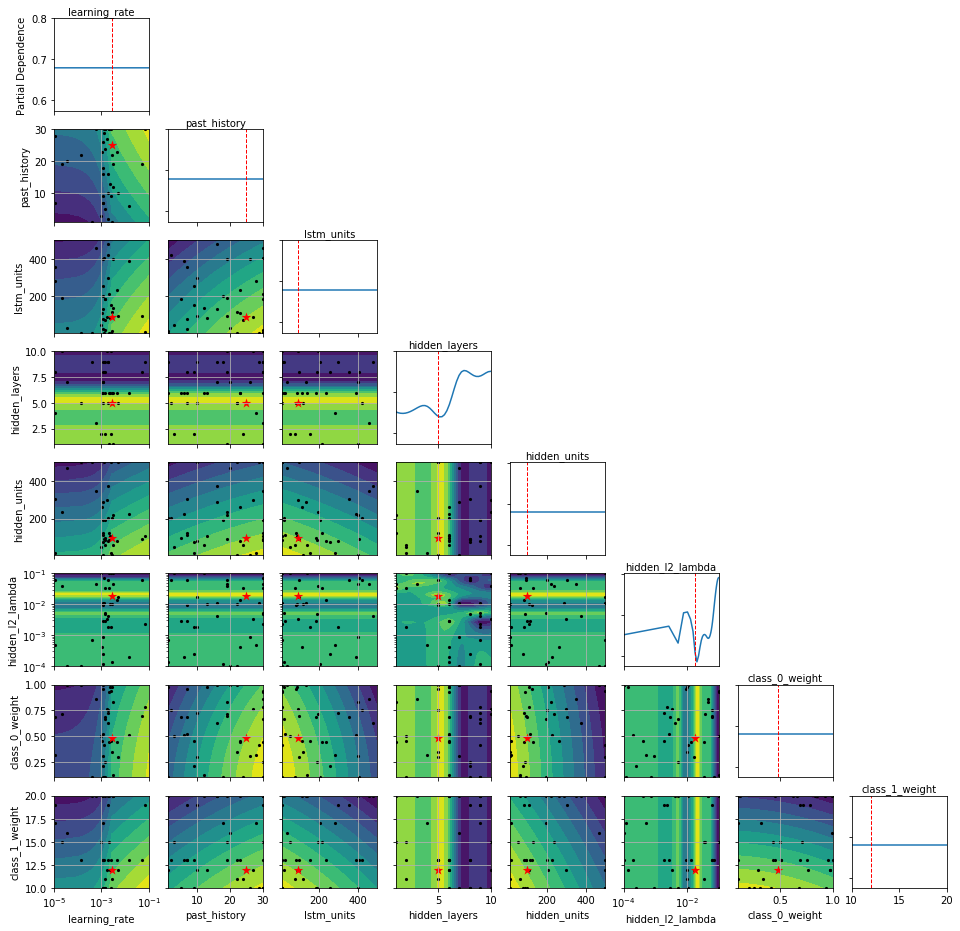

In [19]:
fig, ax = plot_objective(result=search_result, dimension_names=dim_names)

**Try a longer training run with the winning hyperparameters** Some of these, we will manually tweak based on the above graph.

In [28]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.002754143921332031,
 'past_history': 25,
 'lstm_units': 91,
 'hidden_layers': 5,
 'hidden_units': 95,
 'hidden_l2_lambda': 0.01845373292661596,
 'class_0_weight': 0.48264028704212036,
 'class_1_weight': 12}

In [73]:
#learning_rate = winning_hyperparams['learning_rate']
learning_rate = 0.001
past_history = winning_hyperparams['past_history']
lstm_units = winning_hyperparams['lstm_units']
hidden_layers = winning_hyperparams['hidden_layers']
hidden_units = winning_hyperparams['hidden_units']
#lstm_l2_lambda = winning_hyperparams['lstm_l2_lambda']
hidden_l2_lambda = winning_hyperparams['hidden_l2_lambda']
#hidden_l2_lambda = 0.005
class_0_weight = winning_hyperparams['class_0_weight']
class_1_weight = winning_hyperparams['class_1_weight']

future_target = 1
step = 1

initial_bias = -1.4
output_bias = tf.keras.initializers.Constant(initial_bias)
    
class_weight = {0: class_0_weight, 1: class_1_weight}

EPOCHS = 50
BATCH_SIZE = 100
STEPS_PER_EPOCH = (len(training_data) * 0.9) // BATCH_SIZE
VALIDATION_STEPS = (len(validation_data) * 0.9) // BATCH_SIZE

In [74]:
x_train, y_train = multivariate_data(
    training_data, 
    training_data[:, 1], 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % BATCH_SIZE))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

x_validation, y_validation = multivariate_data(
    validation_data, 
    validation_data[:, 1], 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % BATCH_SIZE))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

input_dim = x_train.shape[-2:]

input_shape = (BATCH_SIZE, input_dim[0], input_dim[1])

In [75]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    lstm_units,
    batch_input_shape=input_shape,
#         bias_initializer=keras.initializers.VarianceScaling(
#             scale=1.0,
#             mode='fan_in', 
#             distribution='normal', 
#             seed=None
#         ),
#         kernel_regularizer=keras.regularizers.l2(lstm_l2_lambda),
#         activation = 'relu',
     stateful = True
))
for i in range(hidden_layers):
    model.add(keras.layers.Dense(
        hidden_units,
        bias_initializer=keras.initializers.VarianceScaling(
            scale=1.0,
            mode='fan_in', 
            distribution='normal', 
            seed=None
        ),
        kernel_regularizer=keras.regularizers.l2(hidden_l2_lambda),
        activation = 'relu'
    ))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'sigmoid',
    bias_initializer = output_bias)
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr = learning_rate), 
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [ ]:
history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks = [early_stopping],
    validation_data=(x_validation, y_validation),
    validation_steps=VALIDATION_STEPS,
    class_weight=class_weight,
    workers=8
)

model.save('../trained_models/best_LSTM.keras')

Train on 6300 samples, validate on 2300 samples
Epoch 1/50
5700/6300 [==========================>...] - ETA: 4s - loss: 6.3979 - tp: 186.0000 - fp: 2855.0000 - tn: 2563.0000 - fn: 96.0000 - accuracy: 0.4823 - precision: 0.0612 - recall: 0.6596 - auc: 0.5973 - f1: 0.4918

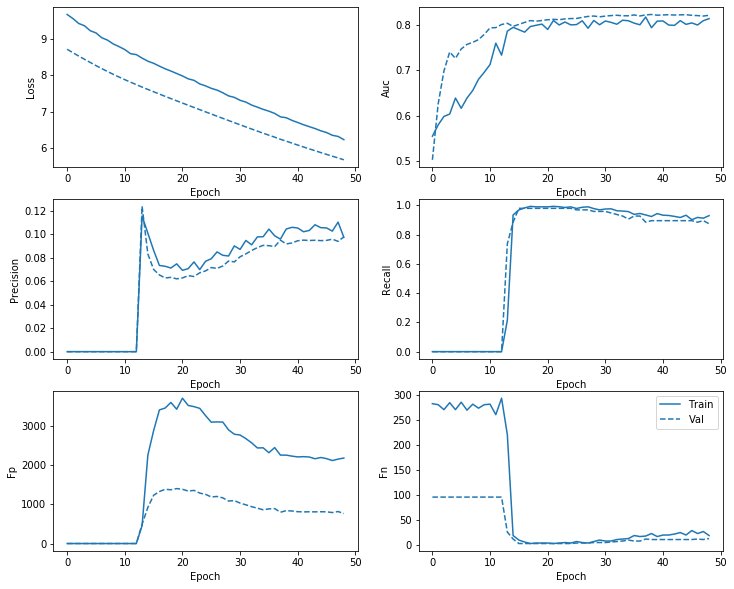

In [72]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plot_metrics(history)

In [26]:
predictions = model.predict(x_train)

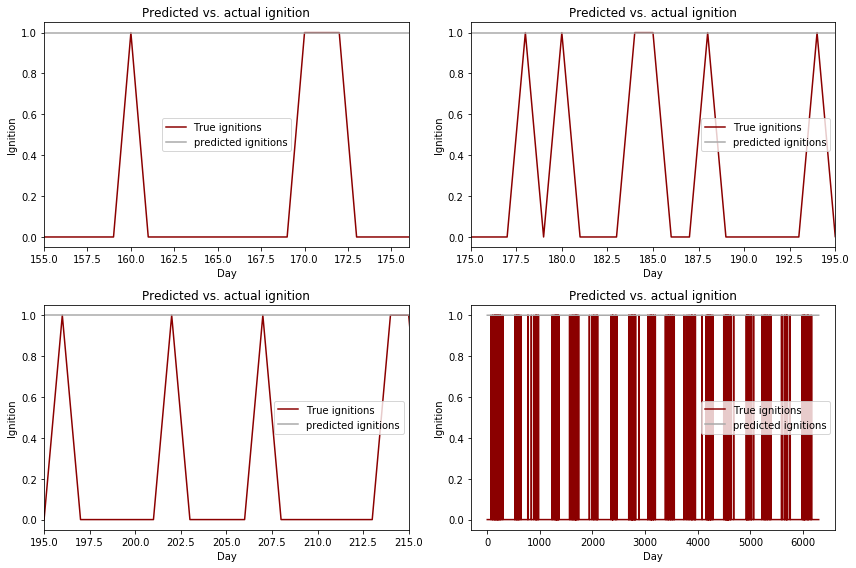

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(2,2,figsize=(12,8))

plt.subplot(2, 2, 1)

plt.plot(
    range(len(y_train)), 
    y_train,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(y_train)), 
    predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(155,176)

plt.subplot(2, 2, 2)

plt.plot(
    range(len(y_train)), 
    y_train,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(y_train)), 
    predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(175,195)

plt.subplot(2, 2, 3)

plt.plot(
    range(len(y_train)), 
    y_train,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(y_train)), 
    predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(195,215)

plt.subplot(2, 2, 4)

plt.plot(
    range(len(y_train)), 
    y_train,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(y_train)), 
    predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
#plt.xlim(195,215)

plt.tight_layout()
plt.show()